## 1. Local and Global Thresholding low level implementations

### 1.1 Global
Global Thresholding is using only one threshold value to binarize image into foreground and background.
### Global thresholding performs badly With Shadows and low contrast regions
Global thresholding is good when foreground and background has clear diffrence; hence low contrast regions, homogenous regions, and shadows are limitations of global thresholding. 


In [1]:
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from task4_util import global_thresholding, adaptative_thresholding, comparison_plot, compare_three_imgs

e:\SBME\2022-2ndtern\cv\tasks\task1-python\assignment-4-cv-2022-sbe-404-team_10\task4_util.py:77: RuntimeWarning: invalid value encountered in double_scalars
  return m/float(w)


optimal threshold 106


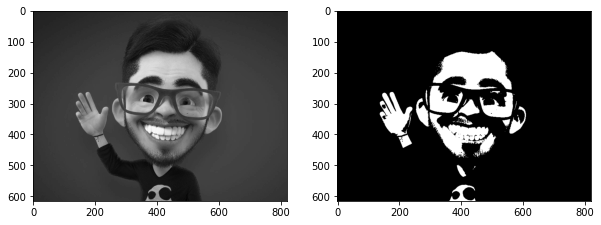

In [2]:
# This implementation uses low level functions implemented from scratch without numpy
image = Image.open('./images/avatar.png').convert("L")
binary_image = global_thresholding(image)
comparison_plot(image, binary_image)

### 1.2 Local Thresholding
We used Bradley implementation for local adaptive image thresholding based on integral image from 
[Bradley Paper Link](https://people.scs.carleton.ca/~roth/iit-publications-iti/docs/gerh-50002.pdf)

Adaptive thresholding is a form of thresholding that takes into account spatial variations in illumination. 
using the integral image of the input is fast method to perform local thresholding. Integral image solution
is more robust to illumination changes in the image. 

one limitation is the size of neighbourhood should be large enough to accomodate suffecient foreground and background.


optimal threshold 139


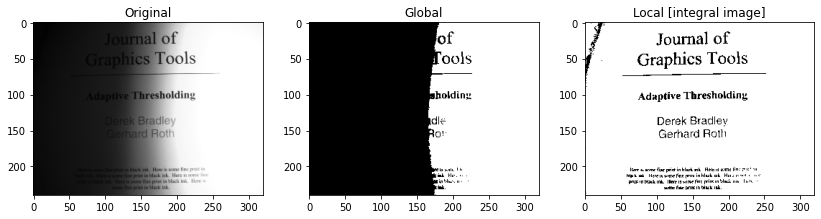

In [4]:
image = Image.open('./images/text.png').convert("L")
img = np.asarray(image)

global_th = global_thresholding(image)
local_th = adaptative_thresholding(img, 20)

compare_three_imgs(image, global_th, local_th, "Original", "Global", "Local [integral image]")


e:\SBME\2022-2ndtern\cv\tasks\task1-python\assignment-4-cv-2022-sbe-404-team_10\test\test_util.py:76: RuntimeWarning: invalid value encountered in double_scalars
  return m/float(w)


optimal threshold 79


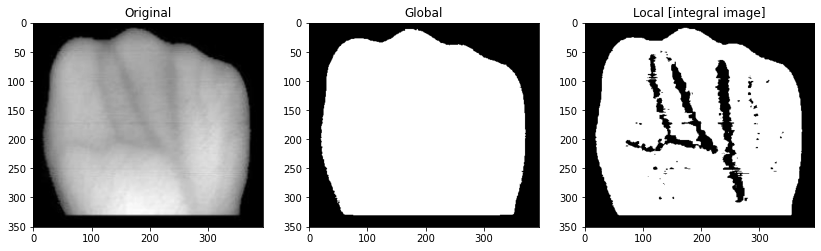

In [23]:
image = Image.open('../images/veins.png').convert("L")
img = np.asarray(image)

global_th = global_thresholding(image)
local_th = adaptative_thresholding(img, 3, 8)

compare_three_imgs(image, global_th, local_th, "Original", "Global", "Local [integral image]")

optimal threshold 157
global time 0.77
integral time 0.26


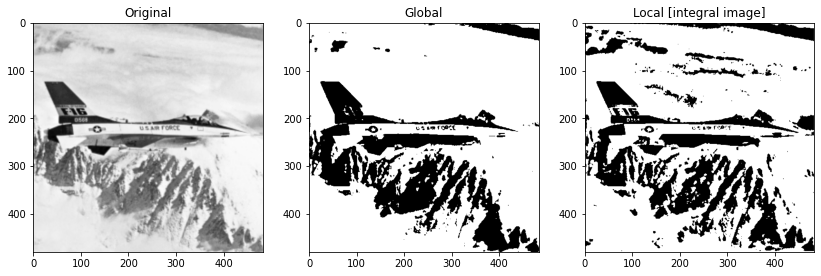

In [9]:
image = Image.open('./images/jet.png').convert("L")
img = np.asarray(image)

tic = time.time()
global_th = global_thresholding(image)
toc = time.time()
print("global time", np.round(toc-tic,2))
tic = time.time()
local_th = adaptative_thresholding(img, 3, 8)
toc = time.time()
print("integral time", np.round(toc-tic,2))
compare_three_imgs(image, global_th, local_th, "Original", "Global", "Local [integral image]")

### 2. Varient to from scratch otsu using numpy. and varient to local thresholding using integral image.

#### 2.1  global otsu  [[Otsu Paper]](https://www.semanticscholar.org/paper/A-threshold-selection-method-from-gray-level-Otsu/1d4816c612e38dac86f2149af667a5581686cdef)
#### 2.2  local  otsu   [`on sub-regions`]
#### 2.3  spectral global otsu  [`2 or more thresholds`]  
 - multiple regions in single channel [MULTI-LEVEL Thresholding Paper](http://smile.ee.ncku.edu.tw/old/Links/MTable/ResearchPaper/papers/2001/A%20fast%20algorithm%20for%20multilevel%20%20thresholding.pdf)
- threshold on spectral image channels (e.g., rgb)   [MULTISPECTRAL THRESHOLDING paper](https://www.researchgate.net/publication/306351469_EDGE_DETECTION_USING_MULTISPECTRAL_THRESHOLDING) as it is not required in our task we separate it to spectral.ipynb
#### 2.4  spectral local otsu  [`2 or more thresholds on image sub-regions`]  
#### 2.5  iterative optimal global thresholding 
#### 2.6  iterative optimal local thresholding


In [5]:
from task4_util import convert_binary, otsu_threshold, otsu_multithreshold, plot_multi_level_otsu, localOtsuThresholding_optimized

## 2.1 Global OTSU

otsu threshold:  105


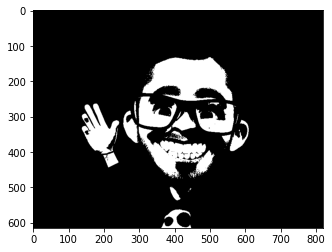

In [11]:
image = Image.open('./images/avatar.png').convert("L")
image = np.asarray(image)

th = otsu_threshold(image)
print("otsu threshold: ", th)

binarized_img = convert_binary(image, th)
plt.imshow(binarized_img, cmap="gray")


## 2.2 Local OTSU
This is just using global otsu on  image sub-regions.

The drawbacks of this method is that the local neighbourhood should not be:
- small: as it will take very long time to compute and the threshold will be easily affected with noise.
- large: as large region will be more affected with illumination and shadows. 

**A major issue with local otsu is not the `time`, but the real issue is the `window edges` which need some interpolation method to result in more meaneangful binary out**

**This can be seen in the below images as the black patches, which is only deacreased by using smaller window**

> The window size of choice should be smaller than the segmented object which explain why the text binarization is behaving badly.
>
> The window showld be large enough to contain pixel values from the classes to have good segmentation. **[it will fail if the window contain one class]**

`Time on text.png`
|Type|time(text.png)|time optimized (text.png)|time(jet.png)| time optimized (jet.png)
|--------|------|-------|-----|------|
|global otsu| < .1 s| < .1 s | .7 s| .7 s |
|local [integral image]|  .1 s|  .1 s| .2 s| .2 s|
|local otsu (window 16)| 39 s |  .07 s| 86.7 s|   0.18 s|
|local otsu (window 32)| 10 s | .02 s| 23.6 s|   0.05 s|
|local otsu (window 64)|  3 s |  .01 s| 6.4 s|   0.02 s|
|local otsu (window 128)|  1 s| < .01 s| 1.8 s|   0.01 s|


>  For text image window 8x8 achieved segmentation similar to local segmentation using integral image in only .29 seconds which is very good result.

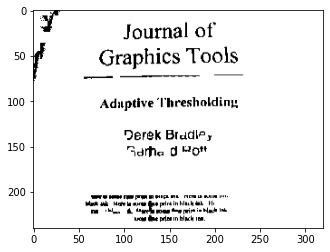

time for 8x8 window: 0.27


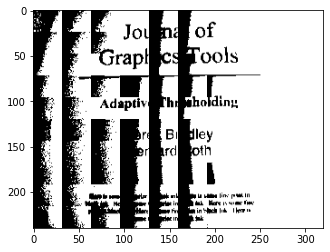

time for 32x32 window: 0.02


In [12]:
windows  = [8, 32]
def plot_local(img):
    plt.imshow(img, cmap="gray")
    plt.show()
for window in windows:
    image = Image.open(f'./images/text.png').convert("L")
    image = np.asarray(image)
    tic = time.time()
    local_th_image = localOtsuThresholding_optimized(image, window)
    toc = time.time()
    plot_local(local_th_image)
    print(f"time for {window}x{window} window: {np.round(toc - tic, 2)}")


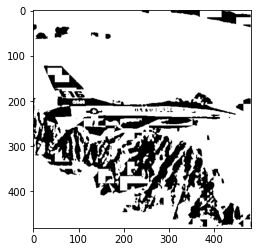

time for 16x16 window: 0.16


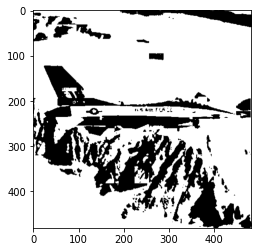

time for 32x32 window: 0.06


In [13]:
windows  = [16, 32]
def plot_local(img):
    plt.imshow(img, cmap="gray")
    plt.show()
for window in windows:
    image = Image.open(f'./images/jet.png').convert("L")
    image = np.asarray(image)
    tic = time.time()
    local_th_image = localOtsuThresholding_optimized(image, window)
    toc = time.time()
    plot_local(local_th_image)
    print(f"time for {window}x{window} window: {np.round(toc - tic, 2)}")


## 2.3  Spectral (Multi-Level) Global OTSU  

otsu multi thresholds:  (156,)


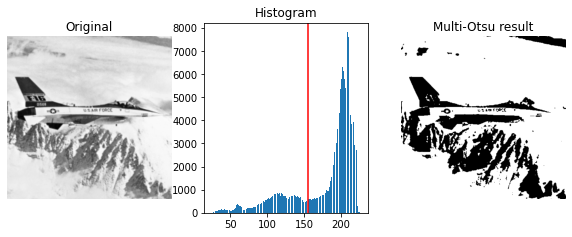

time for multilevel otsu (1 levels) : 0.45
otsu multi thresholds:  (115, 173)


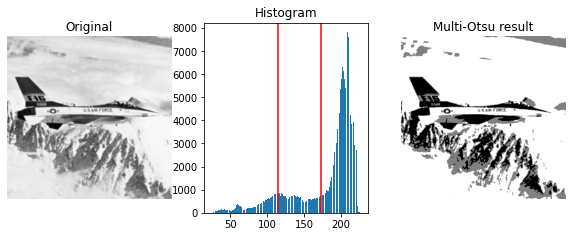

time for multilevel otsu (2 levels) : 0.71
otsu multi thresholds:  (96, 147, 189)


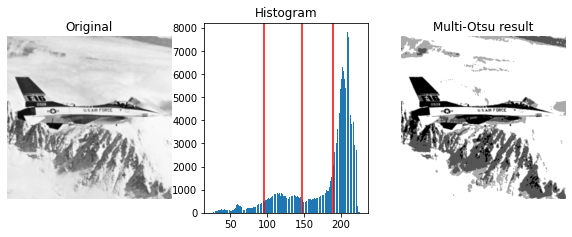

time for multilevel otsu (3 levels) : 20.2


In [14]:
level_list = [1,2,3]
for level in level_list: 
    image = Image.open('./images/jet.png').convert("L")
    image = np.asarray(image) 
    tic = time.time()
    th_list = otsu_multithreshold(image, nthrs=level)
    print("otsu multi thresholds: ", th_list)
    plot_multi_level_otsu(image, th_list)    
    toc = time.time()
    print(f"time for multilevel otsu ({level} levels) : {np.round(toc-tic, 2)}")

## Segmenting multiple medical images using multi level otsu gives very good results in diffrent domains 
- Lung X-Ray
- Swallowing Fluroscopy
- Braim MRI 

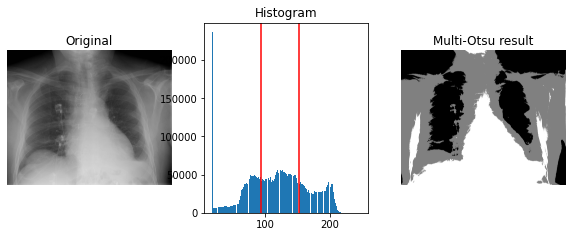

otsu multi thresholds:  (94, 152)
time for multilevel otsu (2 levels) : 1.52


In [21]:
imgs_list = ["lung.jpg"]
level = 2
for img in imgs_list:
    image = Image.open(f'./images/{img}').convert("L")
    image = np.asarray(image) 
    tic = time.time()
    th_list = otsu_multithreshold(image, nthrs=2)
    plot_multi_level_otsu(image, th_list)    
    toc = time.time()
    print("otsu multi thresholds: ", th_list)
    print(f"time for multilevel otsu ({level} levels) : {np.round(toc-tic, 2)}")



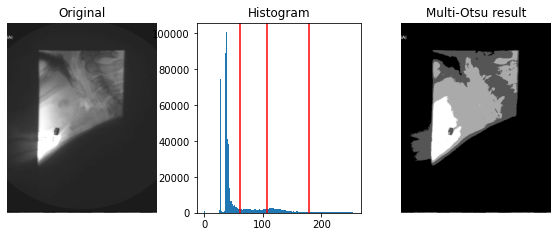

otsu multi thresholds:  (61, 108, 179)
time for multilevel otsu (3 levels) : 20.1


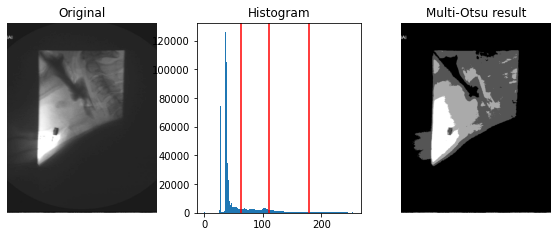

otsu multi thresholds:  (62, 110, 179)
time for multilevel otsu (3 levels) : 20.02


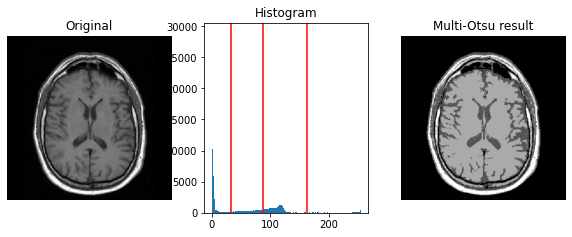

otsu multi thresholds:  (33, 87, 163)
time for multilevel otsu (3 levels) : 19.91


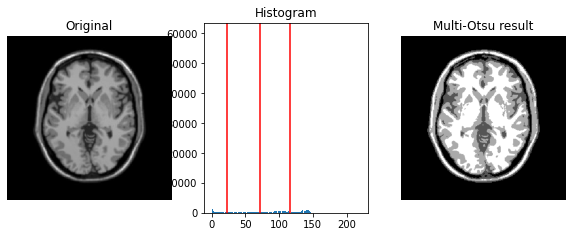

otsu multi thresholds:  (23, 71, 116)
time for multilevel otsu (3 levels) : 20.09


In [20]:
imgs_list = ["ns050a_1.png", "ns050a_2.png", "brain.jpeg", "brain2.jpeg"]
for img in imgs_list:
    image = Image.open(f'./images/{img}').convert("L")
    image = np.asarray(image) 
    tic = time.time()
    th_list = otsu_multithreshold(image, nthrs=3)
    plot_multi_level_otsu(image, th_list)    
    toc = time.time()
    print("otsu multi thresholds: ", th_list)
    print(f"time for multilevel otsu ({level} levels) : {np.round(toc-tic, 2)}")
    


## 2.4  Spectral (Multi-Level) Local OTSU  

In [3]:
from task4_util import local_spectral_multilevel, plot_local_spectral_multilevel

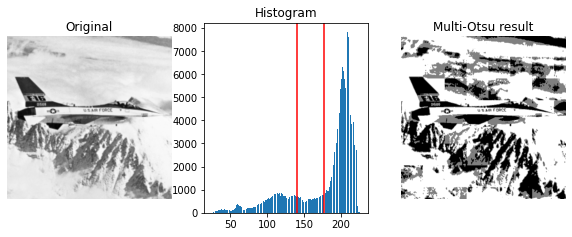

otsu multi thresholds:  (140, 177)
time for multilevel otsu (2 levels) : 14.85


In [4]:

imgs_list = ["jet.png"]
for img in imgs_list:
    image = Image.open(f'./images/{img}').convert("L")
    image = np.asarray(image) 
    tic = time.time()
    digitized_img, th_list = local_spectral_multilevel(image, 64 , 2)
    # plot_multi_level_otsu(image, th_list)  
    plot_local_spectral_multilevel(image, digitized_img, th_list)  
    toc = time.time()
    print("otsu multi thresholds: ", th_list)
    print(f"time for multilevel otsu (2 levels) : {np.round(toc-tic, 2)}")





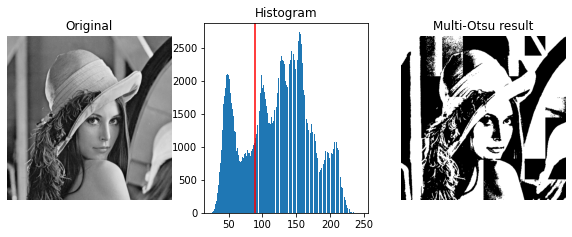

otsu multi thresholds:  (89,)
time for multilevel otsu (2 levels) : 0.57


In [5]:

imgs_list = ["lena.png"]
for img in imgs_list:
    image = Image.open(f'./images/{img}').convert("L")
    image = np.asarray(image) 
    tic = time.time()
    digitized_img, th_list = local_spectral_multilevel(image, 64 , 1)
    # plot_multi_level_otsu(image, th_list)  
    plot_local_spectral_multilevel(image, digitized_img, th_list)  
    toc = time.time()
    print("otsu multi thresholds: ", th_list)
    print(f"time for multilevel otsu (2 levels) : {np.round(toc-tic, 2)}")


## 2.5 Global Iterartive OPtimal Thresholding
Global and Local `iterative optimal thresholding` reached the same result of otsu, but in slower time
|image|global_otsu|global_optimal
|--------|-----------| ---------|
|avatar.png| .02s | .15 s
|lung.jpg| .22 s | 1.63 s|


In [2]:
from task4_util import global_Optimal_Thresholding, local_Optimal_Thresholding

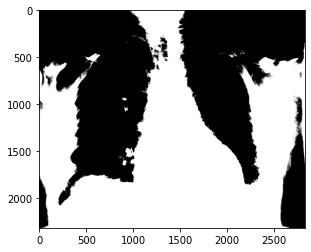

otsu threshold:  119
global otsu time: 0.25


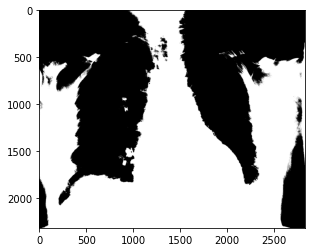

global iterative optimal threshold:  119
global iterative optimal time: 1.61


In [6]:
image = Image.open('./images/lung.jpg').convert("L")
image = np.asarray(image)

tic = time.time()
otsu_th = otsu_threshold(image)
toc = time.time()
otsu_img = convert_binary(image, otsu_th)
plt.imshow(otsu_img, cmap="gray")
plt.show()
print("otsu threshold: ", otsu_th)
print(f"global otsu time: {np.round(toc-tic, 2)}")

tic = time.time()
opt_th = global_Optimal_Thresholding(image)
toc = time.time()
iter_optimal_img = convert_binary(image, opt_th)
plt.imshow(iter_optimal_img, cmap="gray")
plt.show()
print("global iterative optimal threshold: ", otsu_th)
print(f"global iterative optimal time: {np.round(toc-tic, 2)}")


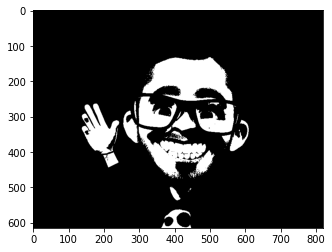

otsu threshold:  105
global otsu time: 0.01


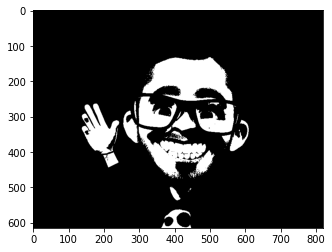

global iterative optimal threshold:  105
global iterative optimal time: 0.12


In [7]:
image = Image.open('./images/avatar.png').convert("L")
image = np.asarray(image)

tic = time.time()
otsu_th = otsu_threshold(image)
toc = time.time()
otsu_img = convert_binary(image, otsu_th)
plt.imshow(otsu_img, cmap="gray")
plt.show()
print("otsu threshold: ", otsu_th)
print(f"global otsu time: {np.round(toc-tic, 2)}")

tic = time.time()
opt_th = global_Optimal_Thresholding(image)
toc = time.time()
iter_optimal_img = convert_binary(image, opt_th)
plt.imshow(iter_optimal_img, cmap="gray")
plt.show()
print("global iterative optimal threshold: ", otsu_th)
print(f"global iterative optimal time: {np.round(toc-tic, 2)}")


## 2.6 Local Iterative Optimal Thresholding

very similar results as local otsu, but slower 

|image|local_otsu|local_optimal|
|--------|--------|-------|
|jet.png| .17 s (window 16x16) & .05 s (window 32x32)|.39 s (window 8x8 ) &  .11 s (window 16x16)|
|text.png| .28 s (window 8x8) & .02 s (window 32x32) | .06 s (window 32x32 ) &  .04 s (window 64x64)|



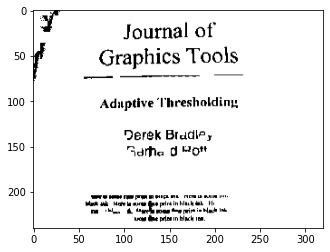

time for 8x8 window: 0.62


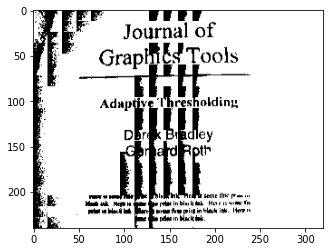

time for 16x16 window: 0.11


In [8]:
windows  = [8, 16]
def plot_local(img):
    plt.imshow(img, cmap="gray")
    plt.show()
for window in windows:
    image = Image.open(f'./images/text.png').convert("L")
    image = np.asarray(image)
    tic = time.time()
    local_th_image = localOtsuThresholding_optimized(image, window)
    toc = time.time()
    plot_local(local_th_image)
    print(f"time for {window}x{window} window: {np.round(toc - tic, 2)}")

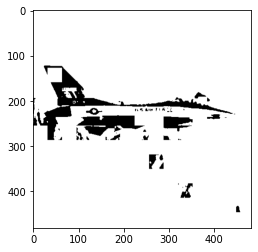

time for 32x32 window: 0.05


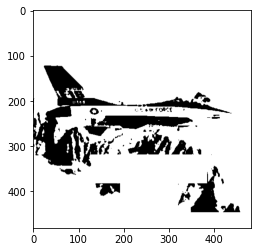

time for 64x64 window: 0.04


In [9]:
windows  = [32,64]
def plot_local(img):
    plt.imshow(img, cmap="gray")
    plt.show()
for window in windows:
    image = Image.open(f'./images/jet.png').convert("L")
    image = np.asarray(image)
    tic = time.time()
    local_th_image = local_Optimal_Thresholding(image, window)
    toc = time.time()
    plot_local(local_th_image)
    print(f"time for {window}x{window} window: {np.round(toc - tic, 2)}")
